In [1]:
from netCDF4 import Dataset
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from scipy.signal import argrelextrema
import pickle
import warnings

In [2]:
directory = '../data/PROCESSED'

In [3]:
pits = pickle.load(open('../data/pickles/kuka_pits.p','rb'))

In [4]:
pits_ = pits.copy()

pits = {}

for key, value in pits_.items():
    
    pits[key] = value

In [5]:
def get_ymd_from_filename(filename):
    
    datestring = filename.split('Scat')[-1][:8]
    
    y = int(datestring[:4])
    m = int(datestring[4:6])
    d = int(datestring[6:8])
    
    return(y,m,d)
def get_time_index(time,times):
    
    deltas = np.array(times) - time

    secs = np.array([d.seconds for d in deltas])
    ms = np.array([d.microseconds for d in deltas])
    
    secs = secs + (ms * 1e-6)
    
    index = np.argmin(secs)
    
    return index


def get_range_index(input_range,ranges):
    
    deltas = np.array(ranges) - input_range
    
    index = np.argmin(np.abs(deltas))
    
    return index

def get_time_ticks(times):
    seconds = [t.second for t in times]
    hours = [t.hour for t in times]
    minutes = [t.minute for t in times]
    time_ticks = [f'{h}:{str(m).zfill(2)}:{str(s).zfill(2)}' for h,m,s in zip(hours, minutes, seconds)]
    return time_ticks

In [6]:
for pitno, data_dict in pits.items():

    y,m,day = get_ymd_from_filename(pits[pitno]['file'])
    
    for freq in ['ka','ku']:

        start_time = datetime.datetime(y,m,day,data_dict[freq][0][0],data_dict[freq][0][1],data_dict[freq][0][2])
        end_time   = datetime.datetime(y,m,day,data_dict[freq][1][0],data_dict[freq][1][1],data_dict[freq][1][2])

        with Dataset(f'{directory}/{data_dict["file"]}') as d:
            ranges = np.array(d['range'])
            times = np.array([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(x)) for x in d['start_time']])

            time_ticks = get_time_ticks(times)
            hh = np.array(d['hh_power_decon0'])
            hv = np.array(d['hv_power_decon0'])
            vv = np.array(d['vv_power_decon0'])

            start_ind = get_time_index(start_time,times)
            end_ind = get_time_index(end_time,times)
            
            pits[pitno][f'{freq}_hh'] = np.mean(hh[:,start_ind:end_ind],axis=1)
            pits[pitno][f'{freq}_vv'] = np.mean(vv[:,start_ind:end_ind],axis=1)
            pits[pitno][f'{freq}_hv'] = np.mean(hv[:,start_ind:end_ind],axis=1)
            pits[pitno][f'{freq}_range'] = ranges

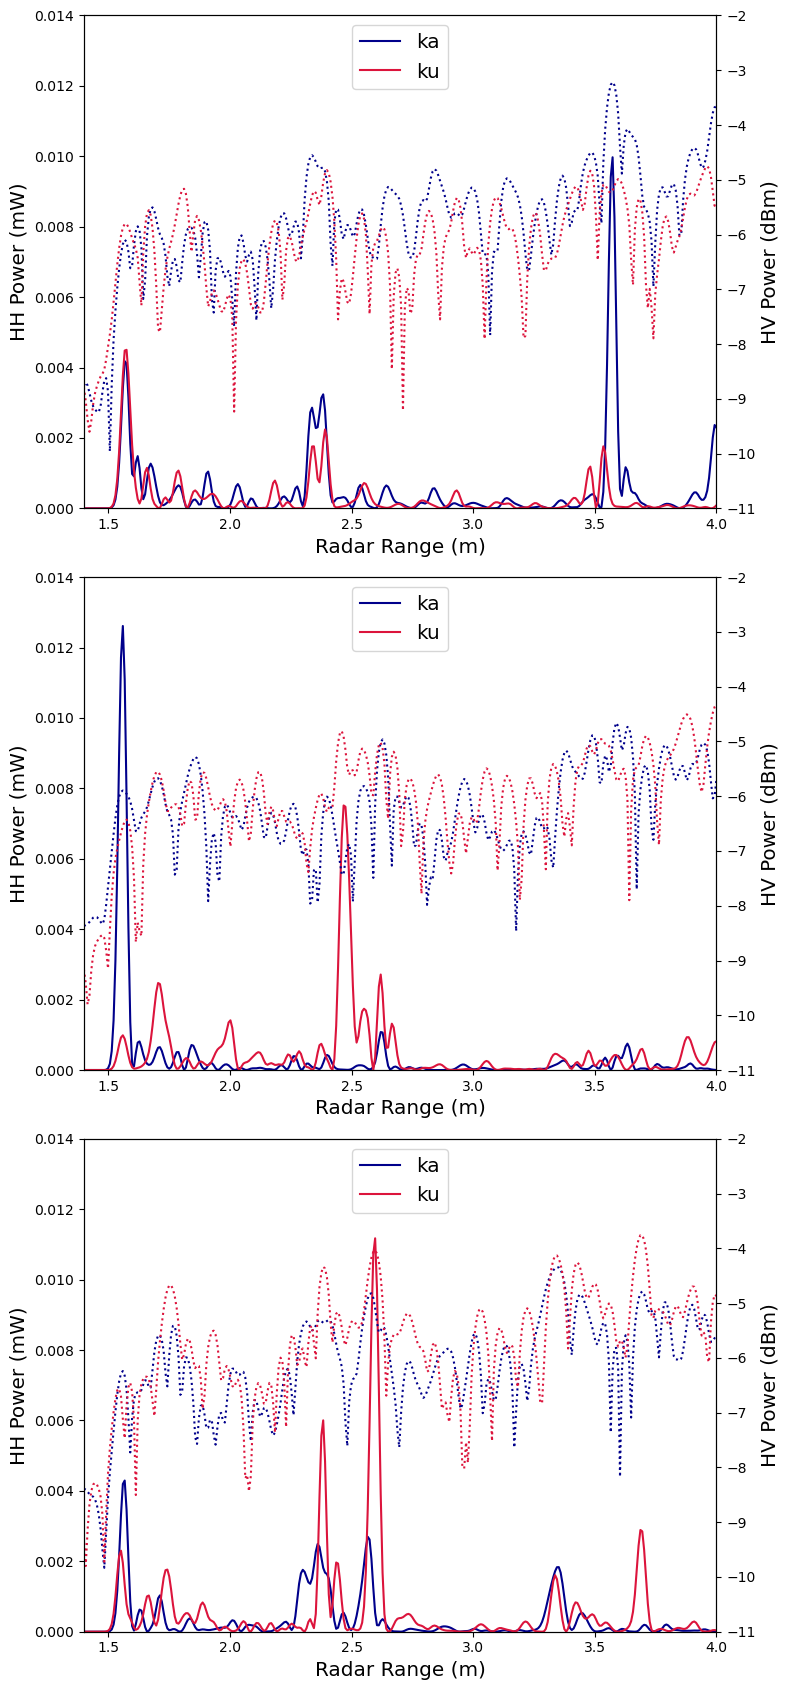

In [83]:
fig1, axs = plt.subplots(3,1,figsize=(8,17))

ylims = {'ku':0.015,'ka':0.015}

for pitno, ax in zip(pits.keys(),axs.reshape(-1)):
    
    data_dict = pits[pitno]
    
    for freq,color in zip(['ka','ku'],['darkblue','crimson']):
        
        ranges = data_dict[f'{freq}_range']
        
        snow_line = data_dict[f'{freq}_hh']

        ax.plot(ranges,snow_line,color=color,label=freq)
        
    ax.set_ylim(0,0.014)
    ax.set_ylabel(f'HH Power (mW)',fontsize='x-large')
    ax.legend(fontsize='x-large',loc='upper center')

    axb = ax.twinx()
    
    for freq,color in zip(['ka','ku'],['darkblue','crimson']):
        
        ranges = data_dict[f'{freq}_range']
        
        snow_line = data_dict[f'{freq}_hv']

        axb.plot(ranges,np.log10(snow_line),color=color,ls=':')
        
    axb.set_ylim(-11,-2)
    axb.set_ylabel(f'HV Power (dBm)',fontsize='x-large')

    


for ax in axs.reshape(-1):
    ax.set_xlim(1.4,4)
    ax.set_xlabel('Radar Range (m)',fontsize='x-large')
    
    
    

plt.tight_layout()
    
plt.savefig('deep_pits_HH_HV',)

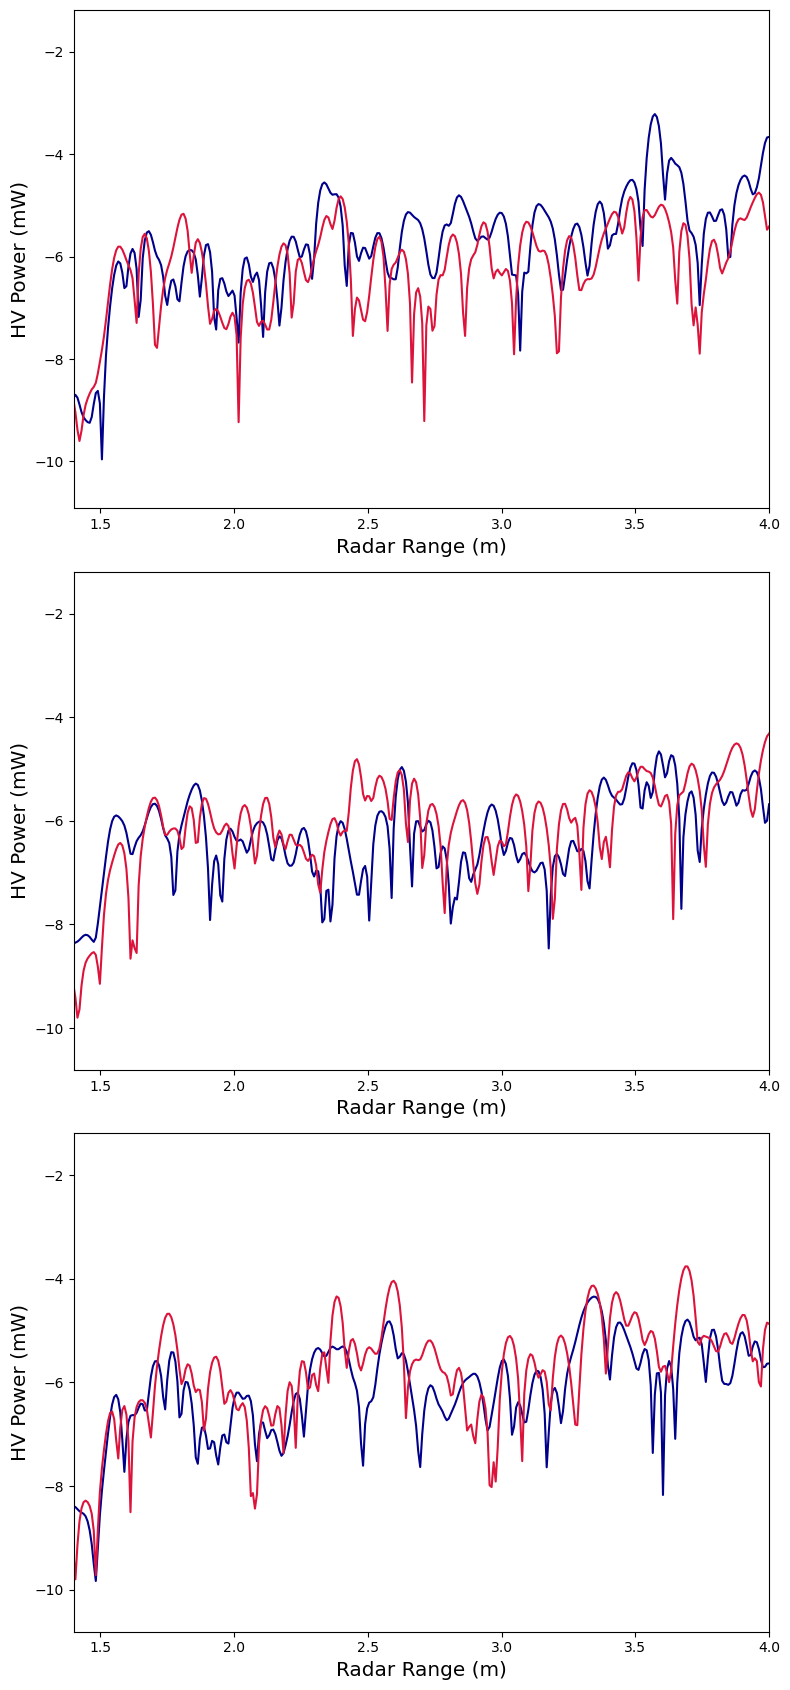

In [77]:
fig1, axs = plt.subplots(3,1,figsize=(8,17))

ylims = {'ku':0.015,'ka':0.015}

for pitno, ax in zip(pits.keys(),axs.reshape(-1)):
    
    data_dict = pits[pitno]
    
    for freq,color in zip(['ka','ku'],['darkblue','crimson']):
        
        ranges = data_dict[f'{freq}_range']
        
        snow_line = data_dict[f'{freq}_hv']

        ax.plot(ranges,np.log10(snow_line),color=color)
        
#     ax.set_ylim(0,0.014)
    ax.set_ylabel(f'HV Power (mW)',fontsize='x-large')


for ax in axs.reshape(-1):
    ax.set_xlim(1.4,4)
    ax.set_xlabel('Radar Range (m)',fontsize='x-large')

plt.tight_layout()
    
plt.savefig('deep_pits_HV.jpg',dpi=400)